# Image classification transfer learning demo

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
3. [Fine-tuning the Image classification model](#Fine-tuning-the-Image-classification-model)
4. [Deploy The Model](#Deploy-the-model)
  1. [Create model](#Create-model)
  2. [Batch transform](#Batch-transform)
  3. [Realtime inference](#Realtime-inference)
    1. [Create endpoint configuration](#Create-endpoint-configuration) 
    2. [Create endpoint](#Create-endpoint) 
    3. [Perform inference](#Perform-inference) 
    4. [Clean up](#Clean-up)


## Introduction

Welcome to our end-to-end example of distributed image classification algorithm in transfer learning mode. In this demo, we will use the Amazon sagemaker image classification algorithm in transfer learning mode to fine-tune a pre-trained model (trained on imagenet data) to learn to classify a new dataset. In particular, the pre-trained model will be fine-tuned using [caltech-256 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech256/). 

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [112]:
%%time
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()

bucket = 'objectdetectchicagoteam2' # customize to your bucket

training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1
CPU times: user 58.9 ms, sys: 10.1 ms, total: 69.1 ms
Wall time: 95.7 ms


In [ ]:
experiment = {
    'tiny-4k-baseline': {
        'job_name': 'tiny-4k',
        'train_data': 'final/tiny_4000'
    },
    'tiny-8k-baseline': {
        'job_name': 'tiny-8k',
        'train_data': 'final/tiny_8000'
    },
    'tiny-16k-baseline': {
        'job_name': 'tiny-16k'
        'train_data': 'final/tiny_16000'
    }
}

class ShipJob:
    pass

## Fine-tuning the Image classification model

The caltech 256 dataset consist of images from 257 categories (the last one being a clutter category) and has 30k images with a minimum of 80 images and a maximum of about 800 images per category. 

The image classification algorithm can take two types of input formats. The first is a [recordio format](https://mxnet.incubator.apache.org/tutorials/basic/record_io.html) and the other is a [lst format](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec). Files for both these formats are available at http://data.dmlc.ml/mxnet/data/caltech-256/. In this example, we will use the recordio format for training and use the training/validation split [specified here](http://data.dmlc.ml/mxnet/data/caltech-256/).

In [165]:
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)

# Our tiny image set
num_training_samples = 16000
s3_train_key = 'final/train_{}'.format(num_training_samples)




s3_train = 's3://{}/{}/'.format(bucket, s3_train_key)
s3_validation_key = 'final/validation'
s3_validation = 's3://{}/{}/'.format(bucket, s3_validation_key)

print(s3_train_key)

final/train_16000


Once we have the data available in the correct format for training, the next step is to actually train the model using the data. Before training the model, we need to setup the training parameters. The next section will explain the parameters in detail.

## Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Input specification**: These are the training and validation channels that specify the path where training data is present. These are specified in the "InputDataConfig" section. The main parameters that need to be set is the "ContentType" which can be set to "application/x-recordio" or "application/x-image" based on the input data format and the S3Uri which specifies the bucket and the folder where the data is present. 
* **Output specification**: This is specified in the "OutputDataConfig" section. We just need to specify the path where the output can be stored after training
* **Resource config**: This section specifies the type of instance on which to run the training and the number of hosts used for training. If "InstanceCount" is more than 1, then training can be run in a distributed manner. 

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **num_training_samples**: This is the total number of training samples. It is set to 15420 for caltech dataset with the current split
* **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For caltech, we use 257 because it has 256 object categories + 1 clutter class
* **epochs**: Number of training epochs
* **learning_rate**: Learning rate for training
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 10 to 12 minutes per epoch on a p2.xlarge machine. The network typically converges after 10 epochs. However, to save the training time, we set the epochs to 2 but please keep in mind that it may not be  sufficient to generate a good model. 

In [166]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = 18
# we need to specify the input image shape for the training data
image_shape = "3,224,224"
# we also need to specify the number of training samples in the training set
# for caltech it is 15420
# specify the number of output classes
num_classes = 2
# batch size for training
mini_batch_size =  10
# number of epochs
epochs = 10
# learning rate
learning_rate = 0.01
top_k=1
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 1

# Training
Run the training using Amazon sagemaker CreateTrainingJob API

In [167]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'Scientist-36-imageclassification'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_train,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_validation,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
    
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: Scientist-36-imageclassification-2019-02-14-16-16-49

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://objectdetectchicagoteam2/final/train_16000/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 5.41 ms, sys: 0 ns, total: 5.41 ms
Wall time: 5.28 ms


"InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": s3_train,
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": ['source-ref', 'class']
                }
            },
            "InputMode": "Pipe",
            "ContentType": "image/jpeg",
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": s3_validation,
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": ['source-ref', 'class']
                }
            },
            "InputMode": "Pipe",
            "ContentType": "image/jpeg",
            "CompressionType": "None",
            "RecordWrapperType": "RecordIO"
        }
    ]

In [168]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

Training job current status: InProgress


### Experiments

In [145]:
from sagemaker.analytics import TrainingJobAnalytics

In [189]:
job_4000 = 'Scientist-36-imageclassification-2019-02-14-15-31-12'
job_desc = sagemaker.describe_training_job(TrainingJobName=job_4000)
status = job_desc['TrainingJobStatus']
#analytics = TrainingJobAnalytics(TrainingJobName=job_4000)

print('Training job current status: {}'.format(status))

Training job current status: Completed


In [187]:
job_8000 = 'Scientist-36-imageclassification-2019-02-14-16-16-08'
status = sagemaker.describe_training_job(TrainingJobName=job_8000)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

Training job current status: Completed


In [193]:
job_16000 = 'Scientist-36-imageclassification-2019-02-14-16-16-49'
status = sagemaker.describe_training_job(TrainingJobName=job_16000)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

Training job current status: Completed


In [100]:
try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [109]:
job_name

'Scientist-36-imageclassification-2019-02-13-22-46-44'

In [102]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


If you see the message,

> `Training job ended with status: Completed`

then that means training sucessfully completed and the output model was stored in the output path specified by `training_params['OutputDataConfig']`.

You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab.

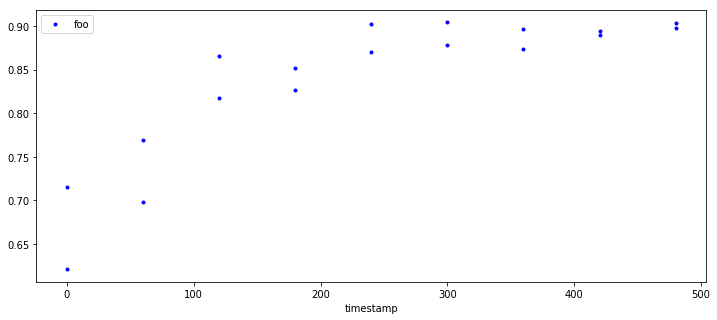

In [181]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

training_job_name = job_4000
train_acc = 'train:accuracy'
val_acc = 'validation:accuracy'

metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[train_acc,val_acc]).dataframe()
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
plt.legend(['foo', 'bar'])
plt.set_ylabel('');

In [191]:
metrics_dataframe.where(metric_name == 'train:accuracy')

ValueError: Array conditional must be same shape as self

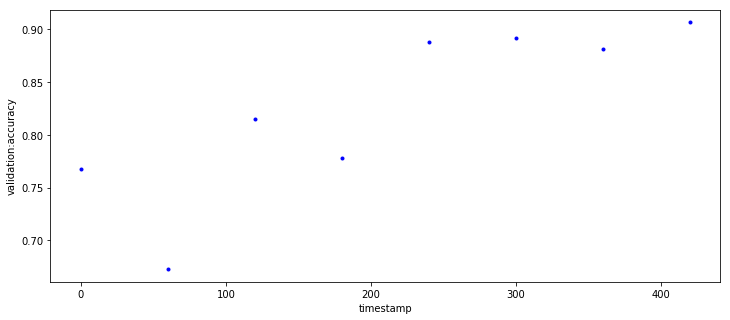

In [156]:
training_job_name = 'Scientist-36-imageclassification-2019-02-14-15-39-14'
metric_name = 'validation:accuracy'

metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
plt.set_ylabel(metric_name);

In [108]:
metrics_dataframe

metric_name  timestamp  value
0  train:accuracy:epoch        0.0    1.0

In [107]:
x = TrainingJobAnalytics(training_job_name=training_job_name)
x = x.dataframe()
list(x)
x

metric_name  timestamp  value
0             train:accuracy        0.0   1.00
1        validation:accuracy        0.0   0.65
2       train:accuracy:epoch        0.0   1.00
3  validation:accuracy:epoch        0.0   0.65

# Deploy The Model

***

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document.

Image-classification only supports encoded .jpg and .png image formats as inference input for now. The output is the probability values for all classes encoded in JSON format, or in JSON Lines format for batch transform.

This section involves several steps,

1. [Create Model](#CreateModel) - Create model for the training output
1. [Batch Transform](#BatchTransform) - Create a transform job to perform batch inference.
1. [Host the model for realtime inference](#HostTheModel) - Create an inference endpoint and perform realtime inference.

## Create Model

We now create a SageMaker Model from the training output. Using the model we can create an Endpoint Configuration.

In [291]:
job_16000

'Scientist-36-imageclassification-2019-02-14-16-16-49'

In [294]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name=job_16000+'-2' #job_name_prefix
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_16000)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

Scientist-36-imageclassification-2019-02-14-16-16-49-2
s3://objectdetectchicagoteam2/Scientist-36-imageclassification/output/Scientist-36-imageclassification-2019-02-14-16-16-49/output/model.tar.gz
arn:aws:sagemaker:us-east-1:023375022819:model/scientist-36-imageclassification-2019-02-14-16-16-49-2
CPU times: user 67.4 ms, sys: 0 ns, total: 67.4 ms
Wall time: 401 ms


### Batch transform

We now create a SageMaker Batch Transform job using the model created above to perform batch prediction.

In [207]:
#!ls -l

#### Download test data


In [206]:
# Download images under /008.bathtub
#!wget -r -np -nH --cut-dirs=2 -P /tmp/ -R "index.html*" http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/


In [214]:
#batch_input = 's3://{}/final/test/'.format(bucket)
#test_images = '/tmp/images/008.bathtub'

#!aws s3 cp $test_images $batch_input --recursive --quiet 

#### Create batch transform job

In [295]:
label = 'SHIP'
batch_input = 's3://{}/final/test/{}'.format(bucket, label)
print('batch_input: {}'.format(batch_input))

#timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
batch_job_name = model_name + '-' + label.replace('_', '-')
print('batch_job_name: {}'.format(batch_job_name))

batch_input: s3://objectdetectchicagoteam2/final/test/SHIP
batch_job_name: Scientist-36-imageclassification-2019-02-14-16-16-49-2-SHIP


In [297]:
request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, batch_job_name)
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": batch_input
            }
        },
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.p2.xlarge",
            "InstanceCount": 1
    }
}

print('Transform job name: {}'.format(batch_job_name))
#print('\nInput Data Location: {}'.format(s3_validation))

Transform job name: Scientist-36-imageclassification-2019-02-14-16-16-49-2-SHIP


In [298]:
sagemaker = boto3.client('sagemaker')
sagemaker.create_transform_job(**request)

{'TransformJobArn': 'arn:aws:sagemaker:us-east-1:023375022819:transform-job/scientist-36-imageclassification-2019-02-14-16-16-49-2-ship',
 'ResponseMetadata': {'RequestId': 'b74d4b6d-8e18-47a5-98d7-9d779c78ff8b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b74d4b6d-8e18-47a5-98d7-9d779c78ff8b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '136',
   'date': 'Thu, 14 Feb 2019 18:44:46 GMT'},
  'RetryAttempts': 0}}

In [300]:
response = sagemaker.describe_transform_job(TransformJobName=batch_job_name)
status = response['TransformJobStatus']
print("Transform job status: " + status)

Transform job status: Completed


In [76]:
print("Created Transform job with name: ", batch_job_name)

while(True):
    response = sagemaker.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    time.sleep(30)  

Created Transform job with name:  image-classification-model-2019-02-13-21-34-40
Transform job ended with status: Completed


After the job completes, let's inspect the prediction results. The accuracy may not be quite good because we set the epochs to 2 during training which may not be sufficient to train a good model. 

In [329]:
no_ship = 'Scientist-36-imageclassification-2019-02-14-16-16-49-2-NO-SHIP'
ship = 'Scientist-36-imageclassification-2019-02-14-16-16-49-2-SHIP'

In [302]:
from urllib.parse import urlparse
import json
import numpy as np

s3_client = boto3.client('s3')
#object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']
object_categories = ['NO_SHIP', 'SHIP']

In [320]:
def list_objects(s3_client, bucket, prefix):
    response = s3_client.list_objects(Bucket=bucket, Prefix=prefix)
    #print(response)
    print('prefix: {}'.format(prefix))
    objects = [content['Key'] for content in response['Contents']]
    print('num. objects: {}'.format(len(objects)))
    return objects

def get_label(s3_client, bucket, prefix):
    filename = prefix.split('/')[-1]
    s3_client.download_file(bucket, prefix, filename)
    with open(filename) as f:
        data = json.load(f)
        index = np.argmax(data['prediction'])
        probability = data['prediction'][index]
    #print("Result: label - " + object_categories[index] + ", probability - " + str(probability))
    return object_categories[index], probability

In [307]:
import sklearn

In [330]:
batch_job_name = ship

#inputs = list_objects(s3_client, bucket, urlparse(batch_input).path.lstrip('/'))
#print("Sample inputs: " + str(inputs[:2]))

outputs = list_objects(s3_client, bucket, batch_job_name + "/output")
#print("Sample output: " + str(outputs[:2]))

# Check prediction result of the first 2 images
#ship_pred = []
#ship_true = []
#for label, score in [get_label(s3_client, bucket, prefix) for prefix in outputs]:
#    if label == 'SHIP':
#        class_idx = 1
#    else:
#        class_idx = 0
#
#    ship_pred.append(label)
#    ship_true.append('SHIP')

prefix: Scientist-36-imageclassification-2019-02-14-16-16-49-2-SHIP/output
num. objects: 1000


In [317]:
batch_job_name

'Scientist-36-imageclassification-2019-02-14-16-16-49-2-SHIP'

In [355]:
outputs = list_objects(s3_client, bucket, ship + "/output")
ship_image_files = ['final/test/SHIP/{}'.format(x.split('/')[2].replace('.out', '')) for x in outputs]
ship_image_files[0:3]

prefix: Scientist-36-imageclassification-2019-02-14-16-16-49-2-SHIP/output
num. objects: 1000


['final/test/SHIP/0002756f7.jpg',
 'final/test/SHIP/00053c6ba.jpg',
 'final/test/SHIP/007b39d27.jpg']

In [354]:
no_ship = 'Scientist-36-imageclassification-2019-02-14-16-16-49-NO-SHIP'
outputs = list_objects(s3_client, bucket, no_ship + "/output")
no_ship_image_files = ['final/test/NO_SHIP/{}'.format(x.split('/')[2].replace('.out', '')) for x in outputs]
no_ship_image_files[0:3]

prefix: Scientist-36-imageclassification-2019-02-14-16-16-49-NO-SHIP/output
num. objects: 1000


['final/test/NO_SHIP/001dd855d.jpg',
 'final/test/NO_SHIP/003857112.jpg',
 'final/test/NO_SHIP/007bcd840.jpg']

In [353]:
'final/test/NO_SHIP/007bcd840.jpg.out'.replace('.out', '')

'final/test/NO_SHIP/007bcd840.jpg'

In [290]:
batch_input

's3://objectdetectchicagoteam2/final/test/NO_SHIP'

In [271]:
batch_job_name = no_ship

inputs = list_objects(s3_client, bucket, urlparse(batch_input).path.lstrip('/'))
#print("Sample inputs: " + str(inputs[:2]))

outputs = list_objects(s3_client, bucket, batch_job_name + "/output")
#print("Sample output: " + str(outputs[:2]))

# Check prediction result of the first 2 images
no_ship_pred = []
no_ship_true = []
for label, score in [get_label(s3_client, bucket, prefix) for prefix in outputs]:
    if label == 'SHIP':
        class_idx = 1
    else:
        class_idx = 0

    no_ship_pred.append(label)
    no_ship_true.append('NO_SHIP')

In [283]:
len(inputs)
#inputs[0]

1000

In [272]:
y_pred = ship_pred + no_ship_pred
y_true = ship_true + no_ship_true

In [281]:
len(no_ship_pred)

1000

In [273]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred, labels = ['SHIP', 'NO_SHIP'])

array([[898, 102],
       [ 57, 943]])

In [274]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(tn, fp, fn, tp)

943 57 102 898


In [357]:
false_ships = [img for img, pred in zip(ship_image_files, ship_pred) if pred != 'SHIP']
len(false_ships)

102

In [358]:
false_no_ships = [img for img, pred in zip(no_ship_image_files, no_ship_pred) if pred != 'NO_SHIP']
len(false_no_ships)

57

In [342]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import boto3
import io

def get_S3_image(image_name):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket('objectdetectchicagoteam2')
    image_object = bucket.Object(image_name)

    image = mpimg.imread(io.BytesIO(image_object.get()['Body'].read()), 'jpg')
    return image

In [345]:
#get_S3_image('final/test/SHIP/0002756f7.jpg')

array([[[ 76, 106,  98],
        [ 97, 127, 119],
        [102, 132, 124],
        ..., 
        [ 99, 128, 123],
        [ 64,  93,  88],
        [ 71, 100,  95]],

       [[ 77, 107,  99],
        [104, 134, 126],
        [ 80, 110, 102],
        ..., 
        [ 85, 114, 109],
        [ 89, 118, 113],
        [ 84, 113, 108]],

       [[ 65,  95,  87],
        [ 67,  97,  89],
        [ 70, 100,  92],
        ..., 
        [ 76, 105, 100],
        [ 69,  98,  93],
        [ 77, 106, 101]],

       ..., 
       [[122, 126, 111],
        [109, 113,  98],
        [115, 117, 103],
        ..., 
        [ 91, 121, 113],
        [ 82, 112, 104],
        [ 70, 100,  92]],

       [[111, 115, 100],
        [105, 109,  94],
        [117, 119, 105],
        ..., 
        [ 64,  94,  86],
        [ 45,  75,  67],
        [ 68,  98,  90]],

       [[109, 113,  98],
        [113, 117, 102],
        [130, 132, 118],
        ..., 
        [105, 135, 127],
        [ 97, 127, 119],
        [101, 131,

Image final/test/NO_SHIP/01ab980a2.jpg


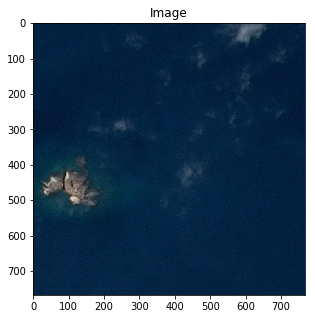

Image final/test/NO_SHIP/02567f5c5.jpg


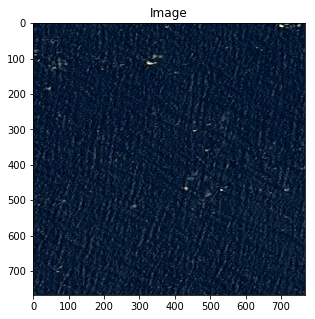

Image final/test/NO_SHIP/0290675c9.jpg


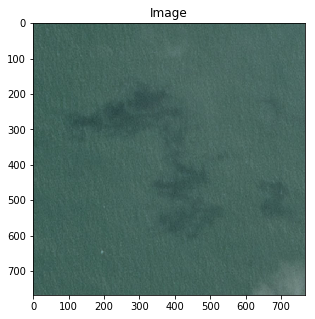

Image final/test/NO_SHIP/031a7628f.jpg


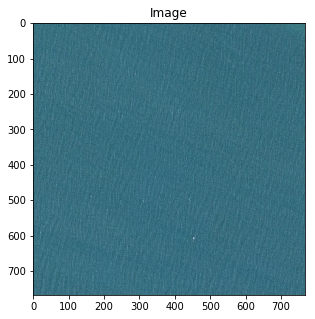

Image final/test/NO_SHIP/03dfe332a.jpg


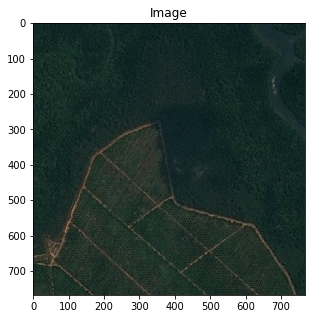

Image final/test/NO_SHIP/0825c397e.jpg


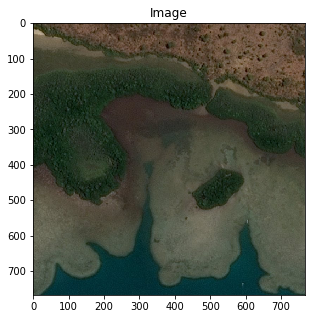

Image final/test/NO_SHIP/08f4d4256.jpg


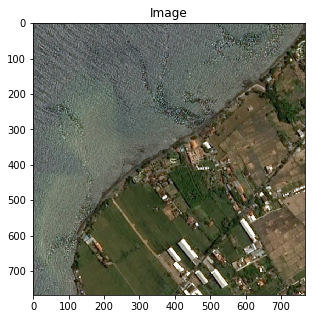

Image final/test/NO_SHIP/097754c90.jpg


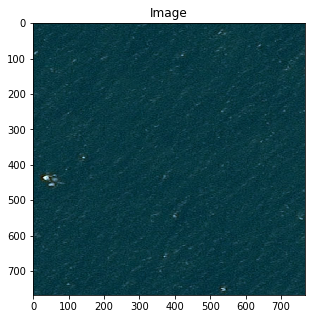

Image final/test/NO_SHIP/09a9a61f2.jpg


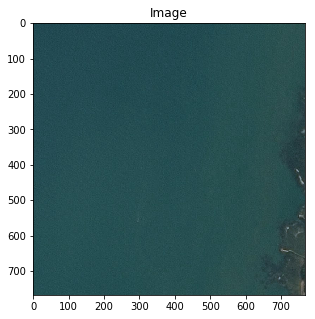

Image final/test/NO_SHIP/0af08e3dd.jpg


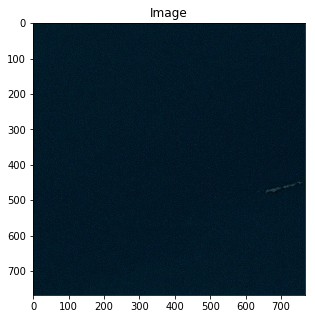

Image final/test/NO_SHIP/0b7dd36d5.jpg


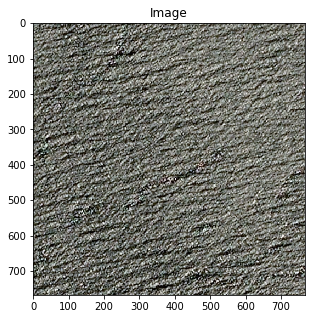

Image final/test/NO_SHIP/142877c99.jpg


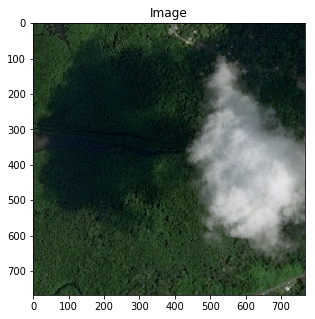

Image final/test/NO_SHIP/15376f87e.jpg


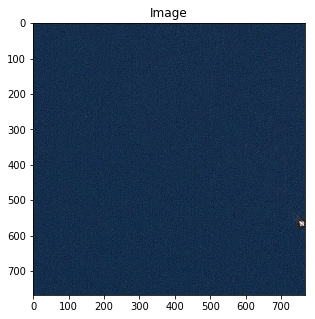

Image final/test/NO_SHIP/15dcd7d68.jpg


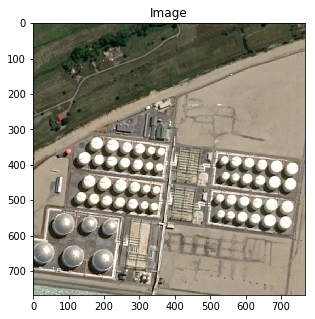

Image final/test/NO_SHIP/16b1ea7dc.jpg


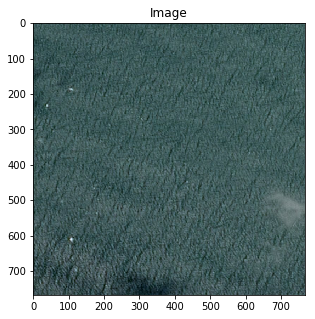

Image final/test/NO_SHIP/184c31c88.jpg


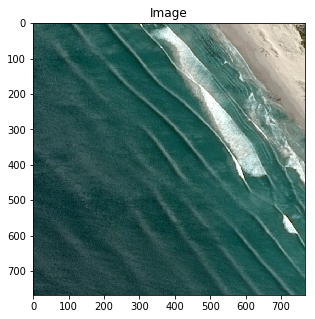

Image final/test/NO_SHIP/1868805ad.jpg


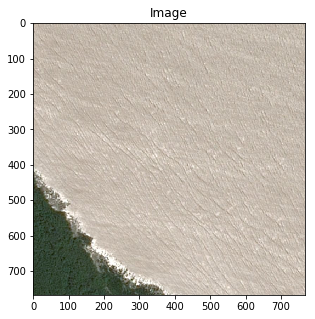

Image final/test/NO_SHIP/18e112157.jpg


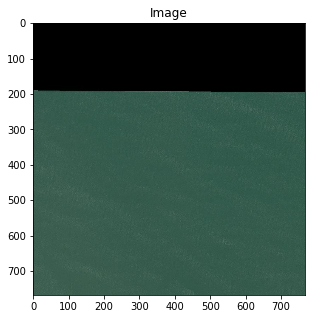

Image final/test/NO_SHIP/1a7901de7.jpg


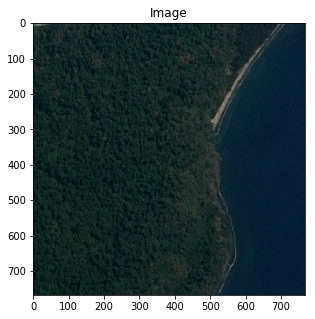

Image final/test/NO_SHIP/1b006a4ac.jpg


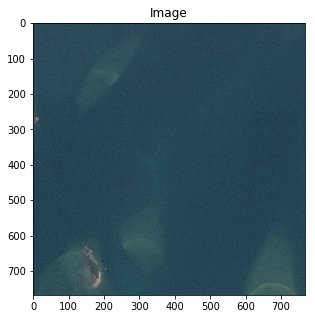

In [407]:
for i in range(20):
    image = false_no_ships[i]

    fig, (ax1) = plt.subplots(1, 1, figsize = (5, 5))
    img_0 = get_S3_image(image)
    #rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    #mask_0 = masks_as_image(rle_0)
    #
    # 
    img_1 = img_0.copy()
    print ('Image', image)

    ax1.imshow(img_0)
    ax1.set_title('Image')
    plt.show()

In [365]:
! pip install tqdm


    100% |████████████████████████████████| 51kB 14.3MB/s ta 0:00:01
mxnet-model-server 0.4 requires mxnet-mkl>=1.2, which is not installed.
mxnet-model-server 0.4 has requirement onnx==1.1.1, but you'll have onnx 1.2.1 which is incompatible.
mxnet-cu90mkl 1.3.0.post0 has requirement requests<2.19.0,>=2.18.4, but you'll have requests 2.20.1 which is incompatible.
keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.0.1 which is incompatible.
You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [380]:
import os
import cv2
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util.montage import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../input'
train_image_dir = 'final/test/SHIP'
test_image_dir = 'testimages'

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [381]:
s3_resource = boto3.resource('s3')
s3_resource.Bucket('objectdetection-ships').download_file('data/train_ship_segmentations_v2.csv', 'train_ship_segmentations_v2.csv')






In [382]:
masks = pd.read_csv('train_ship_segmentations_v2.csv')
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [383]:
images_with_ship = masks.ImageId[masks.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)
print('There are ' +str(len(images_with_ship)) + ' image files with masks')

There are 42556 image files with masks


In [392]:
list(images_with_ship)

['000155de5.jpg',
 '000194a2d.jpg',
 '00021ddc3.jpg',
 '0002756f7.jpg',
 '00031f145.jpg',
 '000532683.jpg',
 '00053c6ba.jpg',
 '0005d01c8.jpg',
 '0005d6d95.jpg',
 '0006c52e8.jpg',
 '000d42241.jpg',
 '000e6378b.jpg',
 '000fd9827.jpg',
 '00113a75c.jpg',
 '001234638.jpg',
 '001566f7c.jpg',
 '0017c19d6.jpg',
 '0018e5d6c.jpg',
 '0019fc4d8.jpg',
 '001aee007.jpg',
 '001bcf222.jpg',
 '001e418bc.jpg',
 '001eb2794.jpg',
 '001ed8b9b.jpg',
 '001eda01f.jpg',
 '0022f64e5.jpg',
 '00269a792.jpg',
 '0027854cc.jpg',
 '002868a5c.jpg',
 '00286e8b9.jpg',
 '002943412.jpg',
 '002c62c03.jpg',
 '002c78530.jpg',
 '002d56570.jpg',
 '002deeb16.jpg',
 '002e85393.jpg',
 '002fdcf51.jpg',
 '00319c32d.jpg',
 '003520305.jpg',
 '00371aa92.jpg',
 '0038cbe45.jpg',
 '003b48a9e.jpg',
 '003d43308.jpg',
 '003e2c95d.jpg',
 '0040cf4e9.jpg',
 '004141855.jpg',
 '0041d7084.jpg',
 '004331bef.jpg',
 '0046d5d83.jpg',
 '00497c23d.jpg',
 '004bc7ae6.jpg',
 '004d7c73a.jpg',
 '004e68ede.jpg',
 '004e94ecb.jpg',
 '004f97cfb.jpg',
 '00552a73

In [402]:
false_ship_files = [x.split('/')[3] for x in false_ships]

In [404]:
false_ship_file_subset = [x for x in images_with_ship if x in false_ship_files]

In [387]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import boto3
import io

def get_S3_image(image_name):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket('objectdetectchicagoteam2')
    image_object = bucket.Object(image_name)

    image = mpimg.imread(io.BytesIO(image_object.get()['Body'].read()), 'jpg')
    return image

In [388]:
train_image_dir

'final/test/SHIP'

key: final/test/SHIP/00053c6ba.jpg
Image 00053c6ba.jpg
Found bbox (124, 736, 139, 752)


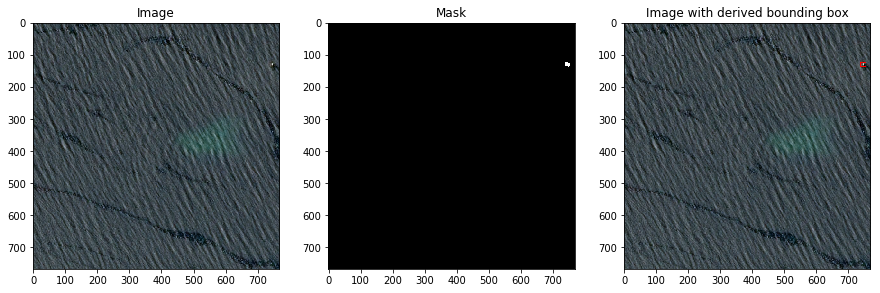

key: final/test/SHIP/02765ce9b.jpg
Image 02765ce9b.jpg
Found bbox (624, 90, 635, 153)
Found bbox (559, 254, 587, 355)
Found bbox (634, 269, 642, 303)
Found bbox (634, 319, 643, 342)
Found bbox (640, 355, 646, 381)
Found bbox (639, 397, 647, 414)
Found bbox (605, 406, 614, 429)
Found bbox (629, 419, 643, 428)


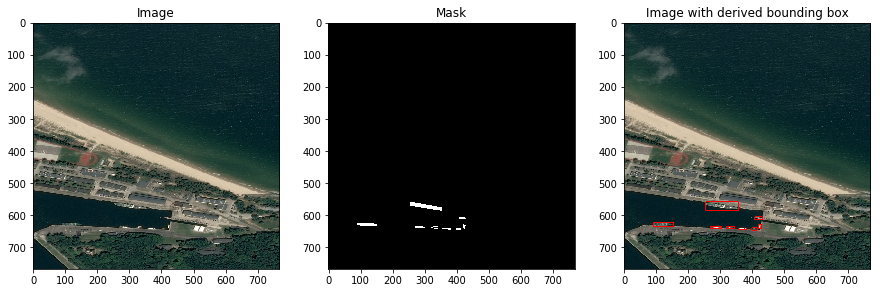

key: final/test/SHIP/031d5ef4e.jpg
Image 031d5ef4e.jpg
Found bbox (558, 30, 588, 111)


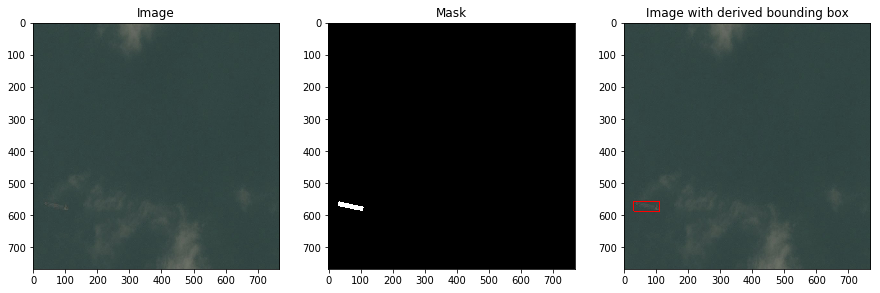

key: final/test/SHIP/0445b541d.jpg
Image 0445b541d.jpg
Found bbox (230, 0, 237, 7)
Found bbox (158, 53, 169, 63)
Found bbox (43, 64, 49, 70)
Found bbox (282, 71, 287, 80)
Found bbox (68, 72, 79, 83)
Found bbox (188, 85, 196, 90)
Found bbox (0, 88, 8, 95)
Found bbox (179, 141, 190, 152)
Found bbox (132, 162, 143, 173)
Found bbox (13, 218, 22, 229)
Found bbox (416, 316, 427, 327)
Found bbox (232, 360, 237, 368)
Found bbox (288, 379, 299, 385)
Found bbox (205, 485, 218, 494)
Found bbox (565, 689, 575, 702)


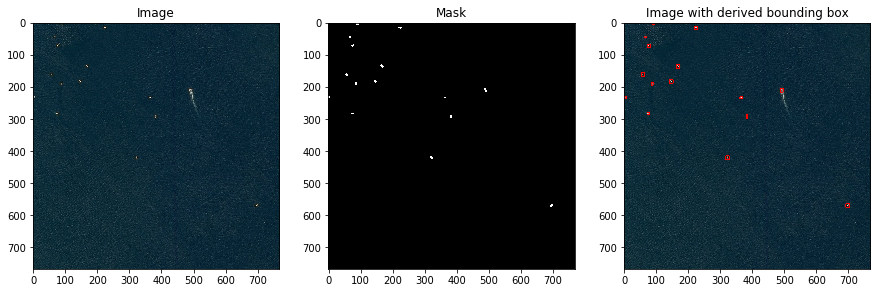

key: final/test/SHIP/086307a36.jpg
Image 086307a36.jpg
Found bbox (326, 397, 336, 407)


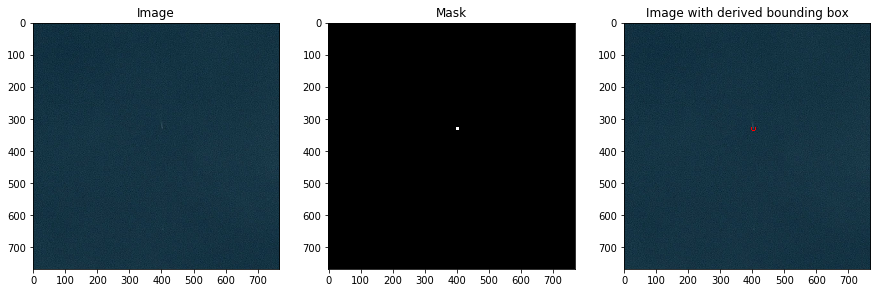

key: final/test/SHIP/08bec3701.jpg
Image 08bec3701.jpg
Found bbox (562, 510, 580, 527)


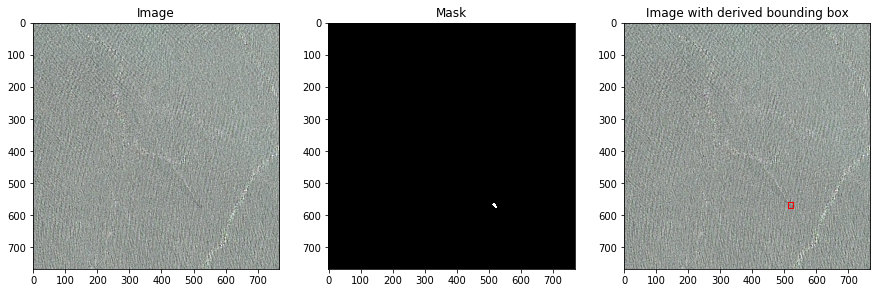

key: final/test/SHIP/0aad46408.jpg
Image 0aad46408.jpg
Found bbox (168, 130, 209, 164)


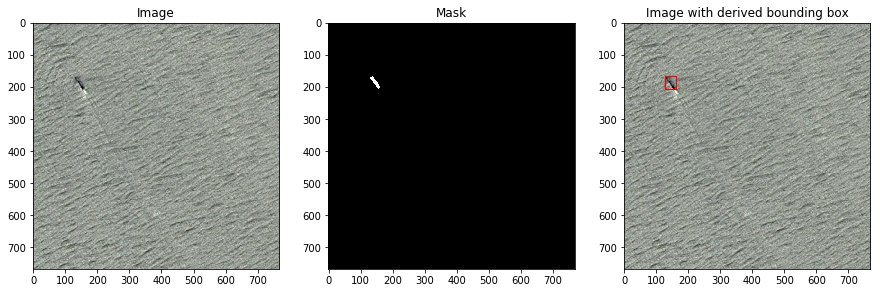

key: final/test/SHIP/0bfe329c6.jpg
Image 0bfe329c6.jpg
Found bbox (575, 426, 597, 447)


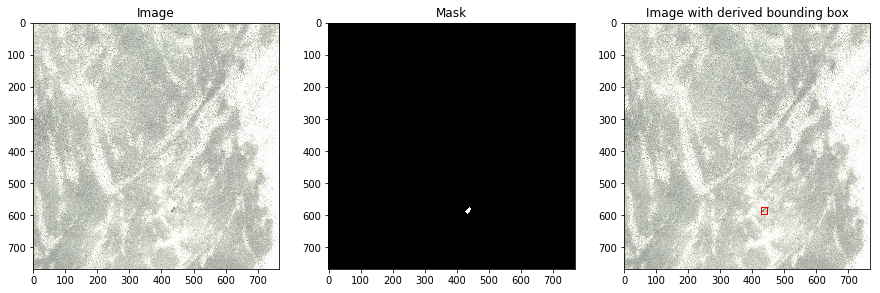

key: final/test/SHIP/0edf7e6f5.jpg
Image 0edf7e6f5.jpg
Found bbox (655, 142, 729, 254)


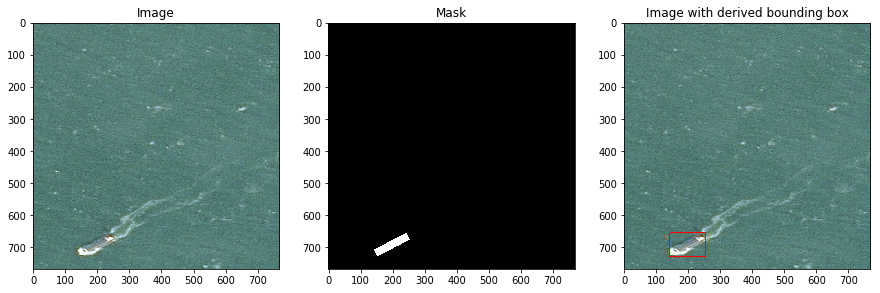

key: final/test/SHIP/1039aceb8.jpg
Image 1039aceb8.jpg
Found bbox (504, 492, 512, 502)


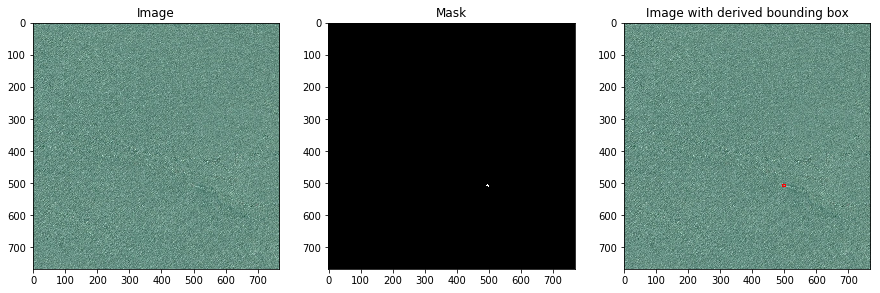

In [405]:
for i in range(10):
    image = false_ship_file_subset[i]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    key = train_image_dir+'/' + image
    print('key: {}'.format(key))
    img_0 = get_S3_image(key)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    #
    # 
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)
    for prop in props:
        print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()

#### Evaluate real no-ship validation images

In [85]:
batch_input = 's3://{}/tiny3/test/NO_SHIP'.format(bucket)

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
batch_job_name = "ships-model-no-ship-validation" + timestamp
request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, batch_job_name)
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": batch_input
            }
        },
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.p2.xlarge",
            "InstanceCount": 1
    }
}

print('Transform job name: {}'.format(batch_job_name))
print('\nInput Data Location: {}'.format(batch_input))

Transform job name: ships-model-no-ship-validation-2019-02-13-21-57-21

Input Data Location: s3://objectdetectchicagoteam2/tiny3/test/NO_SHIP


In [82]:
sagemaker = boto3.client('sagemaker')
sagemaker.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

while(True):
    response = sagemaker.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    time.sleep(30)  

Created Transform job with name:  ships-model-no-ship-validation-2019-02-13-21-51-48
Transform job ended with status: Completed


In [83]:
from urllib.parse import urlparse
import json
import numpy as np

s3_client = boto3.client('s3')
#object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']
object_categories = ['NO_SHIP', 'SHIP']

def list_objects(s3_client, bucket, prefix):
    response = s3_client.list_objects(Bucket=bucket, Prefix=prefix)
    objects = [content['Key'] for content in response['Contents']]
    return objects

def get_label(s3_client, bucket, prefix):
    filename = prefix.split('/')[-1]
    s3_client.download_file(bucket, prefix, filename)
    with open(filename) as f:
        data = json.load(f)
        index = np.argmax(data['prediction'])
        probability = data['prediction'][index]
    print("Result: label - " + object_categories[index] + ", probability - " + str(probability))
    return object_categories[index], probability

inputs = list_objects(s3_client, bucket, urlparse(batch_input).path.lstrip('/'))
print("Sample inputs: " + str(inputs[:2]))

outputs = list_objects(s3_client, bucket, batch_job_name + "/output")
print("Sample output: " + str(outputs[:2]))

# Check prediction result of the first 2 images
[get_label(s3_client, bucket, prefix) for prefix in outputs[0:10]]

Sample inputs: ['tiny3/test/NO_SHIP/2f3d7c434.jpg', 'tiny3/test/NO_SHIP/31d6fdf95.jpg']
Sample output: ['ships-model-no-ship-validation-2019-02-13-21-51-48/output/2f3d7c434.jpg.out', 'ships-model-no-ship-validation-2019-02-13-21-51-48/output/31d6fdf95.jpg.out']
Result: label - NO_SHIP, probability - 0.9732958078384399
Result: label - NO_SHIP, probability - 0.999259889125824
Result: label - NO_SHIP, probability - 0.9827027320861816
Result: label - NO_SHIP, probability - 0.9720324277877808
Result: label - NO_SHIP, probability - 0.9538697600364685
Result: label - NO_SHIP, probability - 0.8932860493659973
Result: label - NO_SHIP, probability - 0.9279369115829468


[('NO_SHIP', 0.9732958078384399),
 ('NO_SHIP', 0.999259889125824),
 ('NO_SHIP', 0.9827027320861816),
 ('NO_SHIP', 0.9720324277877808),
 ('NO_SHIP', 0.9538697600364685),
 ('NO_SHIP', 0.8932860493659973),
 ('NO_SHIP', 0.9279369115829468)]

#### Evaluate real no-ship validation images

In [86]:
batch_input = 's3://{}/tiny3/test/SHIP'.format(bucket)

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
batch_job_name = "ships-model-ship-validation" + timestamp
request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, batch_job_name)
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": batch_input
            }
        },
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.p2.xlarge",
            "InstanceCount": 1
    }
}

print('Transform job name: {}'.format(batch_job_name))
print('\nInput Data Location: {}'.format(batch_input))

Transform job name: ships-model-ship-validation-2019-02-13-21-57-21

Input Data Location: s3://objectdetectchicagoteam2/tiny3/test/SHIP


In [87]:
sagemaker = boto3.client('sagemaker')
sagemaker.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

while(True):
    response = sagemaker.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    time.sleep(30)  

Created Transform job with name:  ships-model-ship-validation-2019-02-13-21-57-21
Transform job ended with status: Completed


In [88]:
from urllib.parse import urlparse
import json
import numpy as np

s3_client = boto3.client('s3')
#object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']
object_categories = ['NO_SHIP', 'SHIP']

def list_objects(s3_client, bucket, prefix):
    response = s3_client.list_objects(Bucket=bucket, Prefix=prefix)
    objects = [content['Key'] for content in response['Contents']]
    return objects

def get_label(s3_client, bucket, prefix):
    filename = prefix.split('/')[-1]
    s3_client.download_file(bucket, prefix, filename)
    with open(filename) as f:
        data = json.load(f)
        index = np.argmax(data['prediction'])
        probability = data['prediction'][index]
    print("Result: label - " + object_categories[index] + ", probability - " + str(probability))
    return object_categories[index], probability

inputs = list_objects(s3_client, bucket, urlparse(batch_input).path.lstrip('/'))
print("Sample inputs: " + str(inputs[:2]))

outputs = list_objects(s3_client, bucket, batch_job_name + "/output")
print("Sample output: " + str(outputs[:2]))

# Check prediction result of the first 2 images
[get_label(s3_client, bucket, prefix) for prefix in outputs[0:10]]

Sample inputs: ['tiny3/test/SHIP/16a177779.jpg', 'tiny3/test/SHIP/6d69b8354.jpg']
Sample output: ['ships-model-ship-validation-2019-02-13-21-57-21/output/16a177779.jpg.out', 'ships-model-ship-validation-2019-02-13-21-57-21/output/6d69b8354.jpg.out']
Result: label - NO_SHIP, probability - 0.9800084829330444
Result: label - NO_SHIP, probability - 0.650273859500885
Result: label - NO_SHIP, probability - 0.8613647222518921


[('NO_SHIP', 0.9800084829330444),
 ('NO_SHIP', 0.650273859500885),
 ('NO_SHIP', 0.8613647222518921)]

### Realtime inference

We now host the model with an endpoint and perform realtime inference.

This section involves several steps,
1. [Create endpoint configuration](#CreateEndpointConfiguration) - Create a configuration defining an endpoint.
1. [Create endpoint](#CreateEndpoint) - Use the configuration to create an inference endpoint.
1. [Perform inference](#PerformInference) - Perform inference on some input data using the endpoint.
1. [Clean up](#CleanUp) - Delete the endpoint and model

#### Create Endpoint Configuration
At launch, we will support configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [ ]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

#### Create Endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [ ]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Finally, now the endpoint can be created. It may take sometime to create the endpoint...

In [ ]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

If you see the message,

> `Endpoint creation ended with EndpointStatus = InService`

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.

We will finally create a runtime object from which we can invoke the endpoint.

#### Perform Inference
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [ ]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

##### Download test image

In [ ]:
!wget -O /tmp/test.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

In [ ]:
import json
import numpy as np
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

#### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [ ]:
sage.delete_endpoint(EndpointName=endpoint_name)